# Reading Data:

In [1]:
import pandas as pd

def read_file(file_path: str) -> pd.DataFrame:
    """
    Reads a CSV file through a given file path.
    """
    return pd.read_csv(file_path)

job_change_df_cleaned = read_file('job_change_df_cleaned.csv')

/var/folders/jq/xzwg3k5d0nqb3574ynkvzc740000gn/T/ipykernel_25582/2661726985.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Visualization #1 — Heatmap:

First, let's visualize the data through a heatmap, to determine the features we should include in the model.

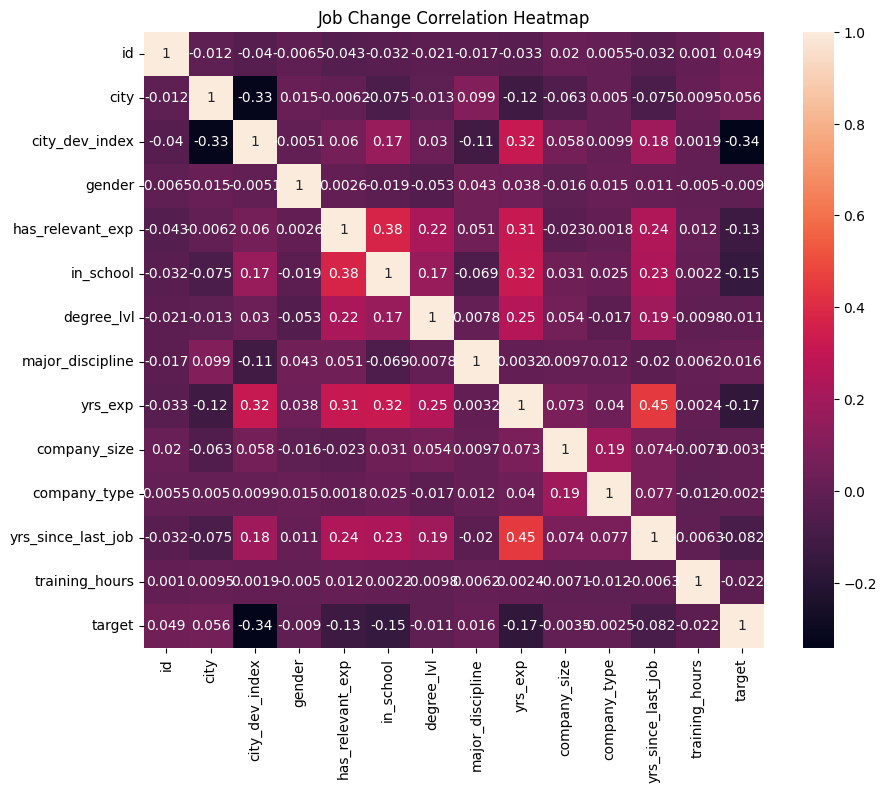

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_heatmap(df: pd.DataFrame) -> None:
    """
    Creates a heatmap of a given DataFrame.
    """
    plt.figure(figsize = (10, 8))
    sns.heatmap(df.corr(), annot = True)
    plt.title('Job Change Correlation Heatmap')
    plt.show()

create_heatmap(job_change_df_cleaned)

As the heatmap illustrates, the top features most correlated with our target are, in order, "City Development Index", "Years of Experience", "In School", and "Has Relevant Experience". The fifth most correlated feature is "Years Since Last Job", though this bears a striking multicollinearity with "Years of Experience", rather intuitively: people who've had invested a long time at their current company, since their last job, necessarily increased their net experience in doing so. As such, we'll exclude the "Years Since Last Job" feature and its measly 8.2% correlation in our models.


The preceding features of "City" and "ID" don't warrant inclusion, either, bearing the highest correlations among the remaining features, though multicollinear (City, with City Index) and confounding (ID) as they are. Given these two are incredibly flawed in their respective ways and yet predict the target best among the remaining columns, I believe cutting off our model's input at "Has Relevant Experience" would be most appropriate, to prevent overfitting.

# Visualization #2 — Box and Whisker Plots:

Next, let's create Box and Whisker Plots for those top four features, to determine generally if their data have any nasty skews or imbalances, which we'll confirm through histograms to come.

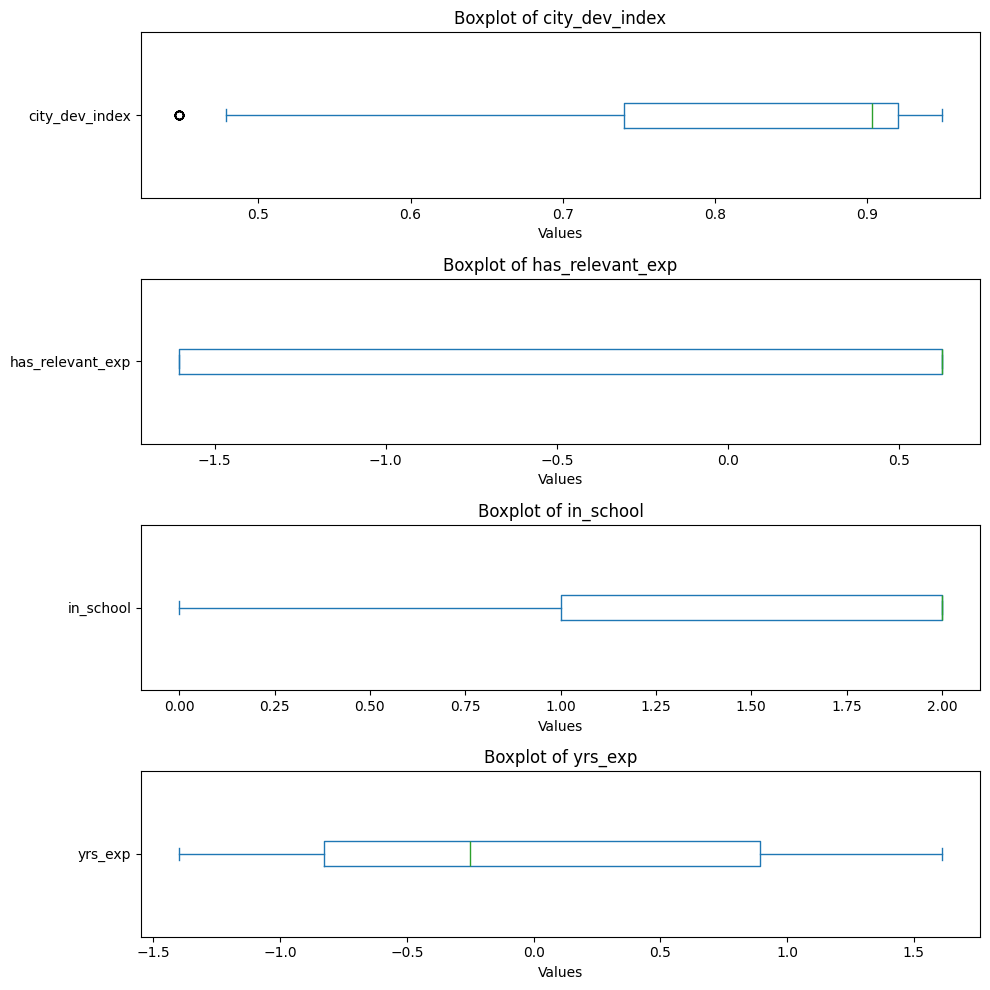

In [3]:
def create_boxplots(dataframe: pd.DataFrame, columns: list[str], figsize: tuple[int, int] = None) -> None:
    """
    Creates box plots for specified columns in a given DataFrame.
    """
    fig, axes = plt.subplots(nrows = len(columns), figsize = figsize)
    
    for i, column in enumerate(columns):
        ax = axes[i]
        dataframe[column].plot(kind = 'box', ax = ax, vert = False)
        ax.set(title = f'Boxplot of {column}', xlabel = 'Values')
    
    plt.tight_layout()
    plt.show()

create_boxplots(job_change_df_cleaned, ["city_dev_index", "has_relevant_exp", "in_school", "yrs_exp"], [10, 10])

The two features which jump out as potentially disproportionate are "Has Relevant Experience" and "In School", whose medians (green line) are plastered against the right side of their plots. Moreover, the quartile cutoffs of "Has Relevant Experience" fill the entire graph, indicating a bimodal distribution with a much greater number of positive than negative points, tracking with the column's two variables we encoded in preprocessing. The box plot of "In School" illustrates similar properties, however its first quartile cutoff rests exactly in the middle of the graph, tracking with a similar narrative of disproportionate positive-to-negative data, whose plot is modified by the existence of a "middle" or "neutral" data type, also tracking with the three variables we encoded for the column, in preprocessing.

The features of "Years of Experience" and "City Development Index" don't bear such patterns—and are thus healthy—for different reasons. For the former, the box plot displays a strikiingly Gaussian form—a normal distribution—indicating that no one data value overpowers another: no stratification will be necessary! The box plot of "City Development Index" presents a less idyllic picture, but a perfectly adeuqate one yet. Although the skew is certainly negative, much like our troublemakers, the considerable offset of this plot's quartile range from its positive outlier cutoff, and expansive outlier cutoff range describe a feature whose stratification would harm our model more than its raw input, especially for our highest-correlation metric. Again, we're looking for extreme imbalances because being too liberal with stratification could easily wound our models' accuracy.

# Visualization #3 — Bar Graphs:

Then, let's validate or reject the imbalances of "Has Relevant Experience" and "In School" through histogram visualization of the features' value counts.

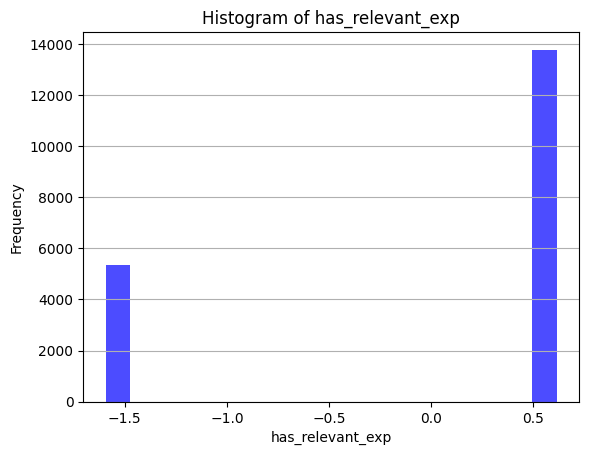

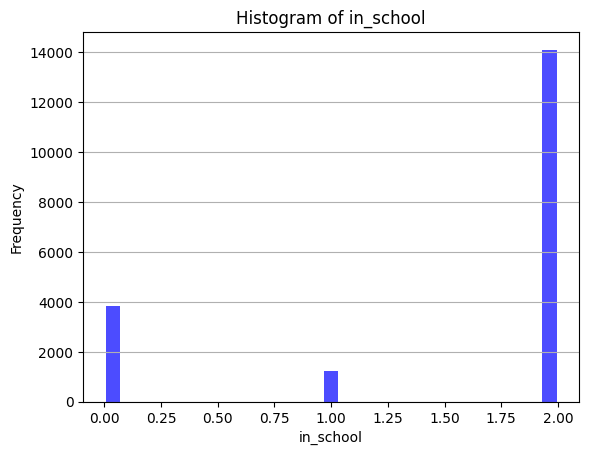

In [4]:
def create_histogram(df: pd.Series, column_name: str):
    """
    Create a histogram for a given column.
    """
    plt.hist(df, bins='auto', color='blue', alpha = 0.7, rwidth = 0.85)
    plt.grid(axis = 'y')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')
    plt.show()

def create_histograms_for_columns(df: pd.DataFrame, columns: list):
    """
    Creates histograms for each specified column in a given DataFrame.
    """
    for column_name in columns:
        if column_name in df.columns:
            create_histogram(df[column_name], column_name)
        else:
            print(f"Column '{column_name}' not found in the DataFrame.")

columns_to_plot = ["has_relevant_exp", "in_school"]

create_histograms_for_columns(job_change_df_cleaned, columns_to_plot)


# Model #1 — Binary Classification:

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

def binary_classification(df: pd.DataFrame, features: list, target: str):
    """
    Perform binary classification on the DataFrame.
    """
    X = df[features]
    y = df[target]
    
    in_school_count = df['in_school'].value_counts().min()
    df_balanced = pd.concat([df[df['in_school'] == False].sample(in_school_count),
                             df[df['in_school'] == True].sample(in_school_count)])
    
    X_train, X_test, y_train, y_test = train_test_split(df_balanced[features], df_balanced[target],
                                                        test_size = 0.1, random_state = 32)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)

features_to_use = ["city_dev_index", "has_relevant_exp", "yrs_exp"]
target_column = "target"

binary_classification(job_change_df_cleaned, features_to_use, target_column)

Accuracy: 0.7745901639344263
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       186
         1.0       0.55      0.29      0.38        58

    accuracy                           0.77       244
   macro avg       0.68      0.61      0.62       244
weighted avg       0.75      0.77      0.75       244

